In [1]:
import sys
sys.path.append("..")

import numpy as np
import matplotlib.pyplot as plt
import rdkit.Chem.AllChem as Chem
from rdkit.Chem import TorsionFingerprints
from rdkit.Chem import rdMolTransforms

import seaborn as sns
sns.set_theme(style="darkgrid")

from idp_rl.environments.environment_components.forcefield_mixins import CharMMMixin, MMFFMixin
import idp_rl.molecule_generation.generate_chignolin

/home/yppatel/anaconda3/envs/idp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
os.environ["MP_RANK"] = "0"
os.getenv("MP_RANK")

'0'

In [3]:
charmm_sim = CharMMMixin()
charmm_sim._seed("GYDPETGTWG")

In [4]:
num_confs = 2000

chignolin = idp_rl.molecule_generation.generate_chignolin.generate_chignolin("GYDPETGTWG")
chignolin.RemoveAllConformers()
Chem.EmbedMultipleConfs(chignolin, numConfs=num_confs)
Chem.MMFFSanitizeMolecule(chignolin)

[20:48:42] Molecule does not have explicit Hs. Consider calling AddHs()


0

In [5]:
def get_gly7_dihedrals(version_mol):
    nonring, ring = TorsionFingerprints.CalculateTorsionLists(version_mol)
    torsions = [nr[0] for nr in nonring]

    full_dihedrals = []
    for conf_id in range(version_mol.GetNumConformers()):
        conf = version_mol.GetConformer(conf_id)
        phi = rdMolTransforms.GetDihedralDeg(conf, *torsions[24][0])
        psi = rdMolTransforms.GetDihedralDeg(conf, *torsions[25][0])
        full_dihedrals.append([phi, psi])
    full_dihedrals = np.array(full_dihedrals)

    return full_dihedrals

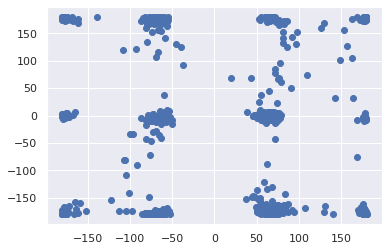

In [6]:
full_dihedrals_nonopt = get_gly7_dihedrals(chignolin)
plt.scatter(full_dihedrals_nonopt[:,0], full_dihedrals_nonopt[:,1])

In [7]:
for i in range(num_confs):
    charmm_sim._optimize_conf(chignolin, i)

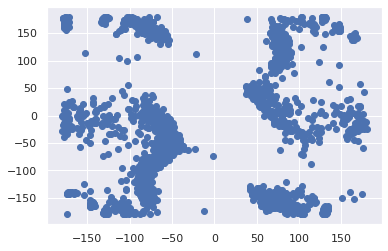

In [8]:
full_dihedrals_opt = get_gly7_dihedrals(chignolin)
plt.scatter(full_dihedrals_opt[:,0], full_dihedrals_opt[:,1])

In [14]:
from sklearn.cluster import KMeans
n_clusters = 8
kmeans = KMeans(n_clusters=n_clusters)
label = kmeans.fit_predict(full_dihedrals_opt)

(-180.0, 180.0)

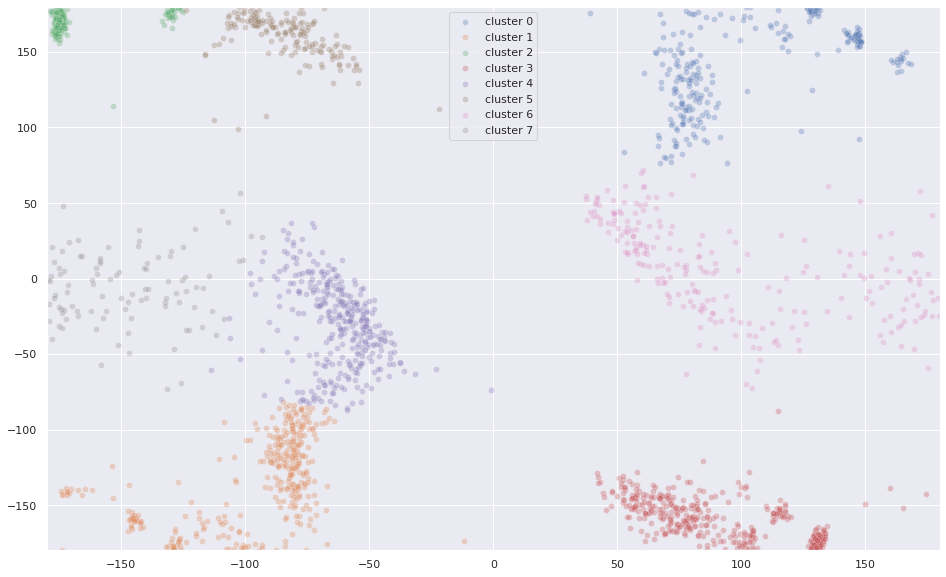

In [15]:
plt.figure(figsize=(16,10))

for label_idx in range(n_clusters):
    sns.scatterplot(
        x=full_dihedrals_opt[label == label_idx,0], 
        y=full_dihedrals_opt[label == label_idx,1],
        palette=sns.color_palette("hls", 10),
        legend="full",
        label=f"cluster {label_idx}",
        alpha=0.3
    )
plt.legend()

plt.xlim(-180, 180)
plt.ylim(-180, 180)